In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
import json
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [42]:
import scipy.signal as signal
import scipy.interpolate as interpolate
import scipy.stats as stats
import time

from finderPeaksSignal import peakFinder

In [43]:
def filterSignal(rawSignal,fs = 25, cutOffFrequency = 5):

    b,a = signal.butter(2, cutOffFrequency, fs=fs, btype='low', analog=False)
    return signal.filtfilt(b,a,rawSignal)

In [62]:
# Read boundingbox file
f = open('leg_raise_task_data.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)
boundingBoxes = data['boundingBoxes']
 
# Closing file
f.close()

In [2]:
## change to video version 
VisionRunningMode = mp.tasks.vision.RunningMode
base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    running_mode = VisionRunningMode.VIDEO)

In [59]:
detector = vision.PoseLandmarker.create_from_options(options)
video = cv2.VideoCapture("MARC_PAPPAS_06_06_2023_DR_DIEGO_GUARIN_LA_R.mp4") 
frameCounter = 0

rightKneeLandmarks = []


while True:
    status,frame = video.read()
    if status == False:
        break

    # detect landmarks     
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)    

    #crop frame based on bounding box info
    x1 = boundingBoxes[frameCounter]['data'][0]['x']
    y1 = boundingBoxes[frameCounter]['data'][0]['y']
    x2 = x1 + boundingBoxes[frameCounter]['data'][0]['width']
    y2 = y1 + boundingBoxes[frameCounter]['data'][0]['height']
    Imagedata = frame[y1:y2,x1:x2,:].astype(np.uint8)
    image = mp.Image(image_format = mp.ImageFormat.SRGB,data=Imagedata)
    detection_result = detector.detect_for_video(image,frameCounter)
    frameCounter = frameCounter+1


    landmarks = detection_result.pose_landmarks[0]
    #these are the coordinates of the landmark that you want to display in the video 
    rightKneeLandmarks.append([landmarks[26].x*(x2-x1), landmarks[26].y*(y2-y1), landmarks[26].z])



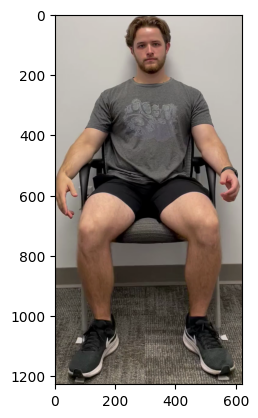

In [50]:
plt.imshow(frame[y1:y2,x1:x2,:])

In [65]:
#get the signal of interest and filter it
signalOfInterest = np.array(rightKneeLandmarks)[:,1]
signalOfInterest = filterSignal(signalOfInterest, cutOffFrequency = 7.5)

#find peaks using custom algorithm
currentFs = 1/int(data['fps'])
desiredFs = 1/60

duration = len(signalOfInterest)*(currentFs)

timeVector = np.linspace(0,duration, int(duration/currentFs))

newTimeVector = np.linspace(0,duration, int(duration/desiredFs))
upsampleSignal = signal.resample(signalOfInterest, len(newTimeVector))

distance, velocity, peaks , indexPositiveVelocity, indexNegativeVelocity = peakFinder(upsampleSignal, fs = 60, minDistance = 3, cutOffFrequency = 7.5, prct = 0.05)

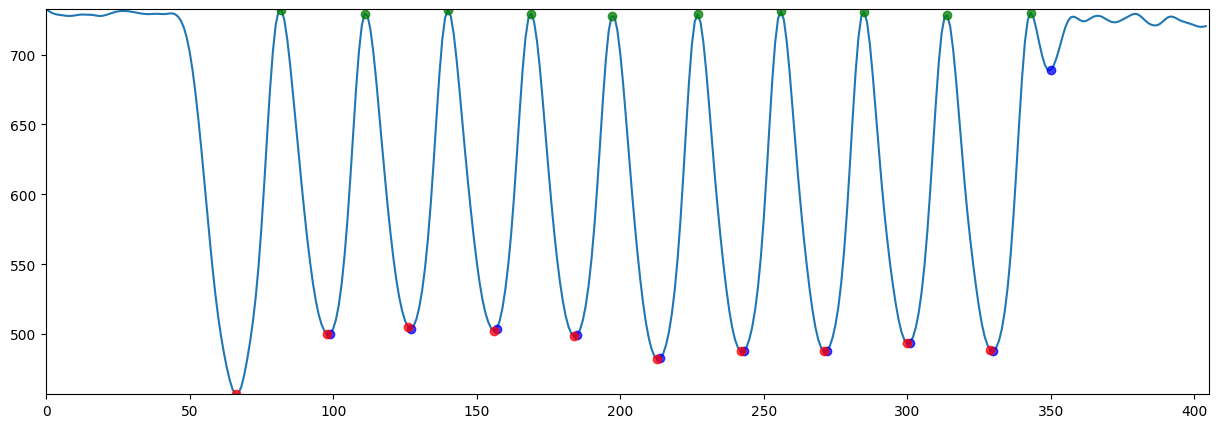

In [70]:
#plot
#a plot like this should appear on the page. 

#green dots -> Peaks
#red dots -> Left Valleys
#blue dots -> Rigth Valleys
figure,ax = plt.subplots(figsize=(15,5))
ax.plot(range(len(sig)), sig)
ax.set_ylim([np.min(sig), np.max(sig)])
ax.set_xlim([0,len(sig)])
for item in peaks :
    ax.plot(item['openingValleyIndex'], sig[item['openingValleyIndex']],'ro', alpha=0.75)
    ax.plot(item['peakIndex'], sig[item['peakIndex']],'go', alpha=0.75)
    ax.plot(item['closingValleyIndex'], sig[item['closingValleyIndex']],'bo', alpha=0.75)

#the code still needs some work. For instance, that last peak shouldn't be detected. 

In [72]:
#find features from the peaks and valleys. This code should be re-run if the person adjusts the peaks and valleys 
amplitude  = []
peakTime = []
rmsVelocity = []
maxOpeningSpeed = []
maxClosingSpeed = []
averageOpeningSpeed = []
averageClosingSpeed = []

for idx,peak in enumerate(peaks):

    #Height measures
    x1 = peak['openingValleyIndex']
    y1 = distance[peak['openingValleyIndex']]

    x2 = peak['closingValleyIndex']
    y2 = distance[peak['closingValleyIndex']]

    x = peak['peakIndex']
    y = distance[peak['peakIndex']]

    f = interpolate.interp1d(np.array([x1,x2]),np.array([y1,y2]))

    amplitude.append(y-f(x))


    #Opening Velocity
    rmsVelocity.append(np.sqrt(np.mean(velocity[peak['openingValleyIndex']:peak['closingValleyIndex']]**2)))

    averageOpeningSpeed.append((y-f(x))/((peak['peakIndex']-peak['openingValleyIndex'])*(1/60)))
    averageClosingSpeed.append((y-f(x))/((peak['closingValleyIndex']-peak['peakIndex'])*(1/60)))

    #timming
    peakTime.append(peak['peakIndex']*(1/60))


meanAmplitude = np.mean(amplitude)
stdAmplitude = np.std(amplitude)

meanRMSVelocity = np.mean(rmsVelocity)
stdRMSVelocity = np.std(rmsVelocity)
meanAverageOpeningSpeed = np.mean(averageOpeningSpeed)
stdAverageOpeningSpeed =  np.std(averageOpeningSpeed)
meanAverageClosingSpeed = np.mean(averageClosingSpeed)
stdAverageClosingSpeed =  np.std(averageClosingSpeed)

meanCycleDuration = np.mean(np.diff(peakTime))
stdCycleDuration = np.std(np.diff(peakTime))
rangeCycleDuration = np.max(np.diff(peakTime)) - np.min(np.diff(peakTime))
rate = len(peaks) / (peaks[-1]['closingValleyIndex'] - peaks[0]['openingValleyIndex'])/(1/60)


earlyPeaks = peaks[:len(peaks)//3]
latePeaks = peaks[-len(peaks)//3:]
amplitudeDecay = np.mean(height[:len(peaks)//3])/np.mean(height[-len(peaks)//3:])
velocityDecay = np.sqrt(np.mean(velocity[earlyPeaks[0]['openingValleyIndex']:earlyPeaks[-1]['closingValleyIndex']]**2)) / np.sqrt(np.mean(velocity[latePeaks[0]['openingValleyIndex']:latePeaks[-1]['closingValleyIndex']]**2)) 
rateDecay = (len(earlyPeaks) / ((earlyPeaks[-1]['closingValleyIndex'] - earlyPeaks[0]['openingValleyIndex'])/(1/60)) ) / ( len(latePeaks) / ((latePeaks[-1]['closingValleyIndex'] - latePeaks[0]['openingValleyIndex'])/(1/60)))


cvAmplitude = stdAmplitude/meanAmplitude
cvCycleDuration = stdCycleDuration/meanCycleDuration
cvRMSVelocity = stdRMSVelocity/meanRMSVelocity
cvAverageOpeningSpeed = stdAverageOpeningSpeed/meanAverageOpeningSpeed
cvAverageClosingSpeed = stdAverageClosingSpeed/meanAverageClosingSpeed


results = np.array([meanAmplitude,stdAmplitude,\
                    meanRMSVelocity, stdRMSVelocity, meanAverageOpeningSpeed, stdAverageOpeningSpeed, meanAverageClosingSpeed, stdAverageClosingSpeed,\
                    meanCycleDuration,stdCycleDuration,rangeCycleDuration,rate,\
                    amplitudeDecay,velocityDecay,rateDecay,\
                    cvAmplitude, cvCycleDuration, cvRMSVelocity, cvAverageOpeningSpeed, cvAverageClosingSpeed])

#results are the features that were extracted from the signal. 
#I think that we can have them in a table for now 